U-Net++ is an advanced variant of the original U-Net architecture designed to improve the accuracy and performance of image segmentation tasks.


 It builds on the U-Net's encoder-decoder structure but introduces additional skip connections and densely connected convolutional layers, making it more robust and capable of handling complex segmentation tasks.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_images='/content/drive/MyDrive/segmentation/aug/train/images'
train_masks='/content/drive/MyDrive/segmentation/aug/train/mask'
val_images='/content/drive/MyDrive/segmentation/aug/val/images'
val_masks='/content/drive/MyDrive/segmentation/aug/val/mask'


In [ ]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize

def load_data(images_path, masks_path, target_size=(256, 256)):
    image_names = sorted(os.listdir(images_path))
    mask_names = sorted(os.listdir(masks_path))

    images = []
    masks = []

    for img_name, mask_name in zip(image_names, mask_names):
        img = imread(os.path.join(images_path, img_name), as_gray=True)
        mask = imread(os.path.join(masks_path, mask_name), as_gray=True)

        img = resize(img, target_size, mode='constant', anti_aliasing=True)
        mask = resize(mask, target_size, mode='constant', anti_aliasing=True)

        img = np.reshape(img, img.shape + (1,))  # Add channel dimension for grayscale
        mask = np.reshape(mask, mask.shape + (1,))  # Add channel dimension for grayscale

        images.append(img)
        masks.append(mask)

    images = np.array(images) / 255.0  # Normalize images to [0, 1]
    masks = np.array(masks) / 255.0  # Normalize masks to [0, 1]

    return images, masks


# Example usage:
augmented_images, augmented_masks = load_data('/content/drive/MyDrive/segmentation/aug/train/images', '/content/drive/MyDrive/segmentation/aug/train/mask')
val_images, val_masks = load_data('/content/drive/MyDrive/segmentation/aug/val/images', '/content/drive/MyDrive/segmentation/aug/val/mask')


In [ ]:
len(augmented_images),len(augmented_masks),len(val_images),len(val_masks)


(48, 48, 12, 12)

In [ ]:
type(augmented_images),type(augmented_masks),len(val_images),len(val_masks)

(numpy.ndarray, numpy.ndarray, 12, 12)

In [ ]:
label_dir='/content/drive/MyDrive/segmentation/segmentaion_labels/train'
image_dir='/content/drive/MyDrive/segmentation/segmentation_images/train'



In [ ]:
import glob
import os
from PIL import Image
import numpy as np

def load_data1(label_path, image_path):
    # Get sorted file paths for images and labels
    label_files = sorted(glob.glob(os.path.join(label_path, '*.png')))
    image_files = sorted(glob.glob(os.path.join(image_path, '*.png')))

    # Loading images and labels
    images = []
    labels = []

    for img_path in image_files:

        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize((256, 256))  # Resize to match augmented data
        img_array = np.array(img)
        images.append(img_array)

    for lbl_path in label_files:
        lbl = Image.open(lbl_path).convert('L')  # Convert to grayscale
        lbl = lbl.resize((256, 256))  # Resize to match augmented data
        lbl_array = np.array(lbl)
        labels.append(lbl_array)

    images_np = np.expand_dims(np.array(images), axis=-1)  # Shape will be (n, 256, 256, 1)
    labels_np = np.expand_dims(np.array(labels), axis=-1)  # Shape will be (n, 256, 256, 1)

    return images_np, labels_np

# Load original data
label_dir = '/content/drive/MyDrive/segmentation/segmentaion_labels/train'
image_dir = '/content/drive/MyDrive/segmentation/segmentation_images/train'

original_images, original_labels = load_data1(label_dir, image_dir)

# Print the loaded data shapes
print(f'Original Images shape: {original_images.shape}')
print(f'Original Labels shape: {original_labels.shape}')


Original Images shape: (30, 256, 256, 1)
Original Labels shape: (30, 256, 256, 1)


In [ ]:
type(original_images),type(original_labels)

original_images.shape




(30, 256, 256, 1)

In [ ]:
train_images, test_images, train_masks, test_masks = train_test_split(
    original_images, original_labels, test_size=0.3, random_state=42
)

print(f"Train Images Shape (Original): {train_images.shape}")
print(f"Test Images Shape: {test_images.shape}")

Train Images Shape (Original): (21, 256, 256, 1)
Test Images Shape: (9, 256, 256, 1)


In [ ]:
combined_train_images = np.concatenate((train_images,augmented_images), axis=0)
combined_train_masks = np.concatenate((train_masks, augmented_masks), axis=0)

print(f"Combined Train Images Shape: {combined_train_images.shape}")
print(f"Combined Train Masks Shape: {combined_train_masks.shape}")


Combined Train Images Shape: (69, 256, 256, 1)
Combined Train Masks Shape: (69, 256, 256, 1)


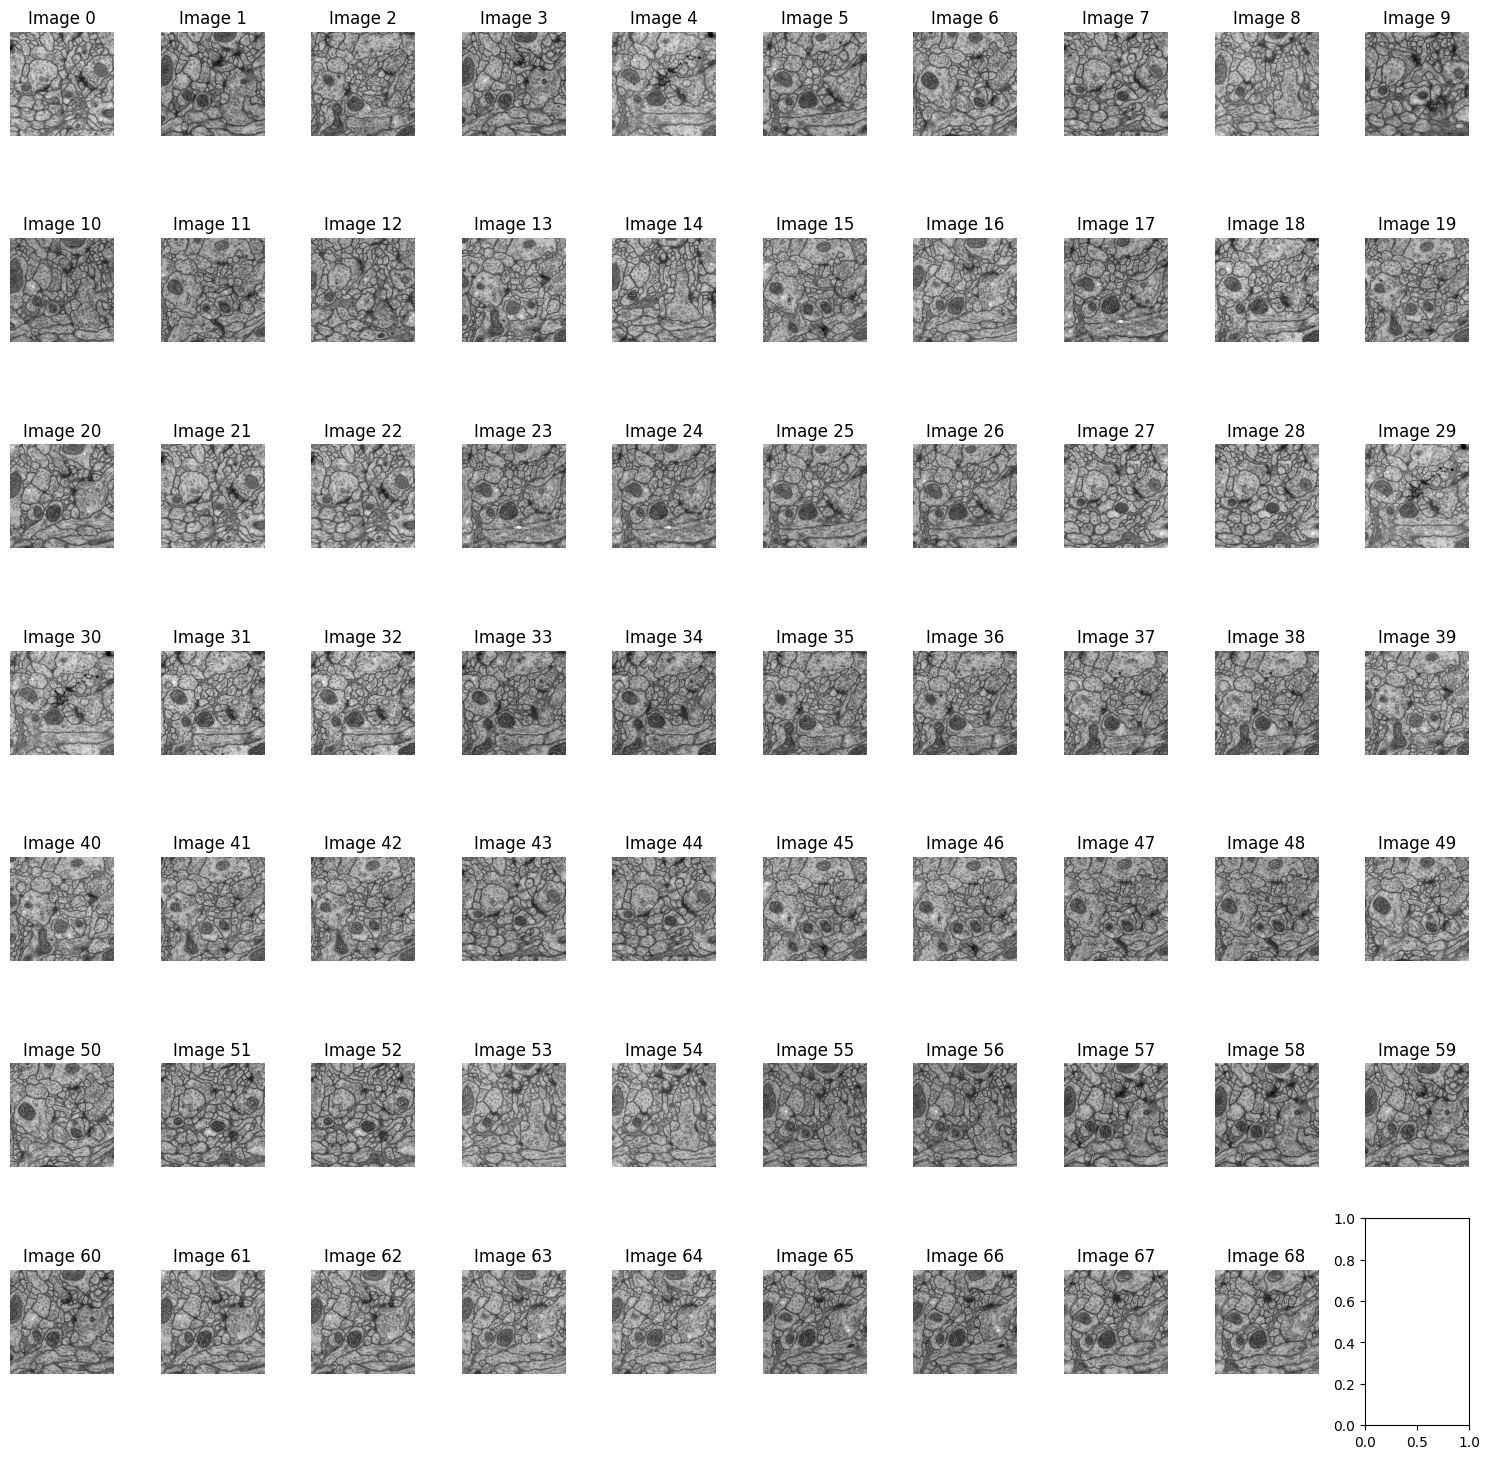

In [ ]:
import matplotlib.pyplot as plt

def visualize_images(images, num_rows=7, num_cols=10):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i in range(num_rows):
        for j in range(num_cols):
            img_index = i * num_cols + j
            if img_index >= len(images):
                break
            # Display image
            axes[i, j].imshow(images[img_index].reshape(256, 256), cmap='gray')
            axes[i, j].set_title(f'Image {img_index}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

visualize_images(combined_train_images)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define custom data generator
class CustomImageMaskDataGenerator:
    def __init__(self, image_datagen, mask_datagen, batch_size):
        self.image_datagen = image_datagen
        self.mask_datagen = mask_datagen
        self.batch_size = batch_size

    def flow(self, images, masks, seed=None):
        image_generator = self.image_datagen.flow(images, batch_size=self.batch_size, seed=seed, shuffle=False)
        mask_generator = self.mask_datagen.flow(masks, batch_size=self.batch_size, seed=seed, shuffle=False)

        while True:
            image_batch = next(image_generator)
            mask_batch = next(mask_generator)
            yield image_batch, mask_batch

# Data Augmentation for Training Data
train_image_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_mask_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the custom data generator
train_generator = CustomImageMaskDataGenerator(
    image_datagen=train_image_datagen,
    mask_datagen=train_mask_datagen,
    batch_size=16
).flow(combined_train_images, combined_train_masks)





In [ ]:
images, masks = next(train_generator)

In [ ]:
def visualize_images(images, masks, batch_size):
    plt.figure(figsize=(12, 12))

    for i in range(batch_size):
        plt.subplot(4, 4, i + 1)
        # Rescale images if needed
        img_to_show = (images[i] * 255).astype(np.uint8)
        plt.imshow(img_to_show)
        plt.title(f"Image {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images(images, masks, batch_size=16)


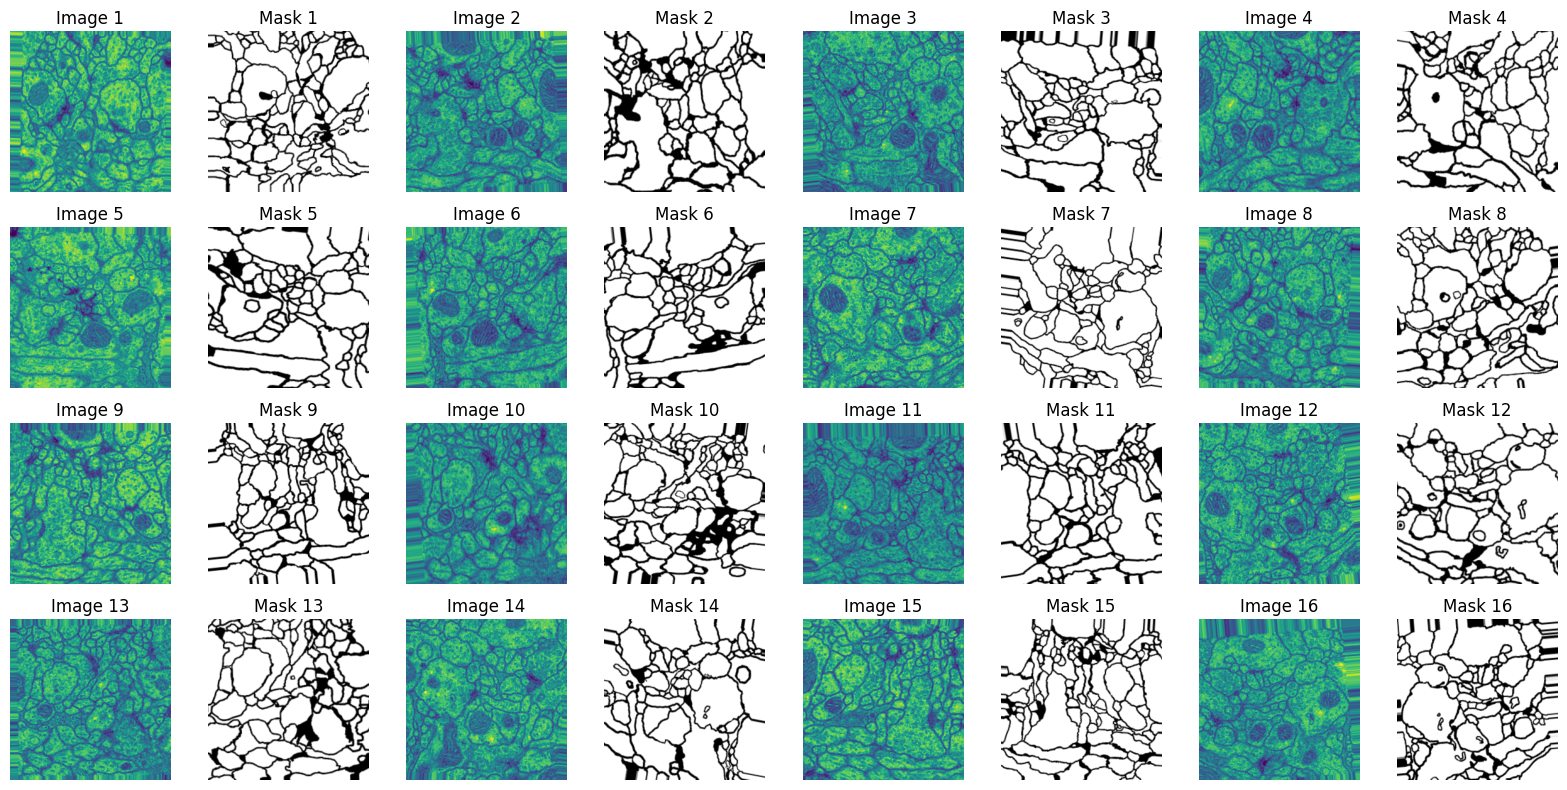

In [ ]:
def visualize_images_with_masks(images, masks, batch_size):
    plt.figure(figsize=(16, 8))

    for i in range(batch_size):
        # Display image
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(images[i].astype(np.uint8))
        plt.title(f"Image {i + 1}")
        plt.axis('off')

        # Display mask
        plt.subplot(4, 8, i * 2 + 2)
        plt.imshow(masks[i].reshape(256, 256), cmap='gray')  # Adjust mask reshaping if needed
        plt.title(f"Mask {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize images with their corresponding masks
visualize_images_with_masks(images, masks, batch_size=16)


In [ ]:
# import numpy as np
# import os
# import skimage.io as io
# import skimage.transform as trans
# import numpy as np
# from keras.models import *
# from keras.layers import *
# from keras.optimizers import *
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as keras

# def unet_plus_plus(pretrained_weights=None, input_size=(256, 256, 1), n_classes=1):
#     inputs = Input(input_size)

#     # Encoder (Downsampling)
#     c1_1 = conv_block(inputs, 64)
#     p1 = MaxPooling2D((2, 2))(c1_1)

#     c2_1 = conv_block(p1, 128)
#     p2 = MaxPooling2D((2, 2))(c2_1)

#     c3_1 = conv_block(p2, 256)
#     p3 = MaxPooling2D((2, 2))(c3_1)

#     c4_1 = conv_block(p3, 512)
#     p4 = MaxPooling2D((2, 2))(c4_1)

#     # Bridge
#     c5_1 = conv_block(p4, 1024)

#     # Decoder (Upsampling)
#     u4_2 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5_1)
#     u4_2 = concatenate([u4_2, c4_1])
#     c4_2 = conv_block(u4_2, 512)

#     u3_3 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c4_2)
#     u3_3 = concatenate([u3_3, c3_1])
#     c3_3 = conv_block(u3_3, 256)

#     u2_4 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c3_3)
#     u2_4 = concatenate([u2_4, c2_1])
#     c2_4 = conv_block(u2_4, 128)

#     u1_5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c2_4)
#     u1_5 = concatenate([u1_5, c1_1])
#     c1_5 = conv_block(u1_5, 64)

#     # Output
#     outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c1_5)

#     model = Model(inputs=[inputs], outputs=[outputs])
#     model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

#     if pretrained_weights:
#         model.load_weights(pretrained_weights)

#     return model

# def conv_block(input_tensor, num_filters):
#     x = Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal')(input_tensor)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     return x

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def unet_plus_plus(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Down-sampling path (Backbone)
    x00 = conv_block(inputs, 32)
    p1 = MaxPooling2D(pool_size=(2, 2))(x00)

    x10 = conv_block(p1, 64)
    p2 = MaxPooling2D(pool_size=(2, 2))(x10)

    x20 = conv_block(p2, 128)
    p3 = MaxPooling2D(pool_size=(2, 2))(x20)

    x30 = conv_block(p3, 256)
    p4 = MaxPooling2D(pool_size=(2, 2))(x30)

    x40 = conv_block(p4, 512)

    # Up-sampling path with dense skip connections
    x01 = conv_block(concatenate([x00, UpSampling2D(size=(2, 2))(x10)], axis=3), 32)
    x11 = conv_block(concatenate([x10, UpSampling2D(size=(2, 2))(x20)], axis=3), 64)
    x21 = conv_block(concatenate([x20, UpSampling2D(size=(2, 2))(x30)], axis=3), 128)
    x31 = conv_block(concatenate([x30, UpSampling2D(size=(2, 2))(x40)], axis=3), 256)

    x02 = conv_block(concatenate([x00, x01, UpSampling2D(size=(2, 2))(x11)], axis=3), 32)
    x12 = conv_block(concatenate([x10, x11, UpSampling2D(size=(2, 2))(x21)], axis=3), 64)
    x22 = conv_block(concatenate([x20, x21, UpSampling2D(size=(2, 2))(x31)], axis=3), 128)

    x03 = conv_block(concatenate([x00, x01, x02, UpSampling2D(size=(2, 2))(x12)], axis=3), 32)
    x13 = conv_block(concatenate([x10, x11, x12, UpSampling2D(size=(2, 2))(x22)], axis=3), 64)

    x04 = conv_block(concatenate([x00, x01, x02, x03, UpSampling2D(size=(2, 2))(x13)], axis=3), 32)

    # Final output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x04)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Create and compile the model
model = unet_plus_plus(input_size=(256, 256, 1))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 256, 256, 32)   │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ conv2d_62[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 32)   │            128 │ conv2d_63[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 128, 128, 32)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 64)   │            256 │ conv2d_64[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 64)   │            256 │ conv2d_65[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 64, 64)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_9[0][0]  │
├──────────────────────

 Total params: 9,170,049 (34.98 MB)

 Trainable params: 9,162,753 (34.95 MB)

 Non-trainable params: 7,296 (28.50 KB)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='unet_plus_plus_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam



model = unet_plus_plus(input_size=(256, 256, 1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Set callbacks
checkpoint = ModelCheckpoint('unet_plus_plus_best.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=len(combined_train_images) // 16,
    validation_data=(val_images,val_masks),
    validation_steps=len(val_images) // 16,
    epochs=5,
    callbacks=[checkpoint, early_stopping]
)



